In [1]:
import torch
from torch import nn
import pandas as pd
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

In [2]:
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 2
PATIANCE = 10
LEARNING_RATE = 1e-4
NUM_CLASSES = 10
PATCH_SIZE = 4
IMAGE_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 8
DROPUT = 0.001
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION = "gelu"
NUM_ENCODERS = 4
EMBEDING_DIMENTION = (PATCH_SIZE**2) * IN_CHANNELS # 16
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2 # 49

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Cuda Specific 
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Apple Metal Specific 
torch.mps.manual_seed(RANDOM_SEED)

In [3]:
if torch.backends.mps.is_available(): 
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

mps


In [18]:
class PositionalEmbeddingStrategy(nn.Module):
    def forward(self, x):
        raise NotImplementedError("Each Embedding Strategy must implement the forward method.")

class PatchEmbeddingLearnedPositionalEmbedding(PositionalEmbeddingStrategy):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size
            ),
            nn.Flatten(2)
        )

        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches + 1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x
    
class PatchEmbeddingNoPositionalEmbedding(PositionalEmbeddingStrategy):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size
            ),
            nn.Flatten(2)
        )

        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat((cls_token, x), dim=1)
        x = self.dropout(x)
        return x

In [6]:
class Vit(nn.Module):
    def __init__(self, embedding_strategy, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self.embedings_block = embedding_strategy

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.embedings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0 , :])
        return x

In [7]:
train_df = pd.read_csv("../mnist_train.csv")
test_df = pd.read_csv("../mnist_test.csv")

In [8]:
train_df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
test_df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

In [11]:
class MNISTTrainDataset():
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self. indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28,28)).astype(np.uint8)  
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "label": label, "index": index}

In [12]:
class MNISTValDataset():
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self. indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28,28)).astype(np.uint8)  
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "label": label, "index": index}

In [13]:
class MNISTTestDataset():
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self. indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28,28)).astype(np.uint8)  
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "label": label, "index": index}

54000
------------------------------
6000
------------------------------
10000


Text(0.5, 1.0, 'Test Image')

<Figure size 640x480 with 0 Axes>

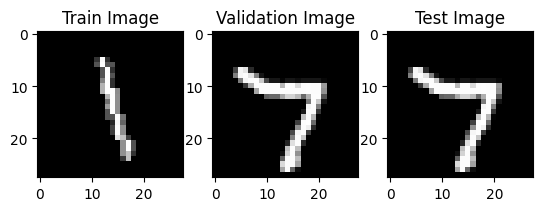

In [14]:
plt.figure()
f, axarr = plt.subplots(1, 3)

train_dataset = MNISTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)
print(len(train_dataset))
axarr[0].imshow(train_dataset[0]["image"].squeeze(), cmap="gray")
axarr[0].set_title("Train Image")
print("-"*30)


val_dataset = MNISTValDataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values)
print(len(val_dataset))
axarr[1].imshow(val_dataset[0]["image"].squeeze(), cmap="gray")
axarr[1].set_title("Validation Image")
print("-"*30)


test_dataset = MNISTTestDataset(test_df.iloc[:, 1:].values.astype(np.uint8), test_df.iloc[:, 0].values, test_df.index.values)
print(len(test_dataset))
axarr[2].imshow(val_dataset[0]["image"].squeeze(), cmap="gray")
axarr[2].set_title("Test Image")

In [15]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False)

/Users/nihat/mambaforge/envs/bachelor-project/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 106/106 [00:08<00:00, 12.05it/s]


Epoch 1: New best model saved with val_loss: 1.8904


 50%|█████     | 1/2 [00:37<00:37, 37.29s/it]

------------------------------
Train Loss EPOCH 1: 2.2279
Valid Loss EPOCH 1: 1.8904
Train Accuracy EPOCH 1: 0.18548148148148147
Valid Accuracy EPOCH 1: 0.35403703703703704
------------------------------


100%|██████████| 106/106 [00:08<00:00, 12.00it/s]


Epoch 2: New best model saved with val_loss: 1.4352


100%|██████████| 2/2 [01:13<00:00, 36.88s/it]

------------------------------
Train Loss EPOCH 2: 1.6174
Valid Loss EPOCH 2: 1.4352
Train Accuracy EPOCH 2: 0.4920185185185185
Valid Accuracy EPOCH 2: 0.5913703703703703
------------------------------
Completed all epochs without early stopping.
Training Time: 73.80s


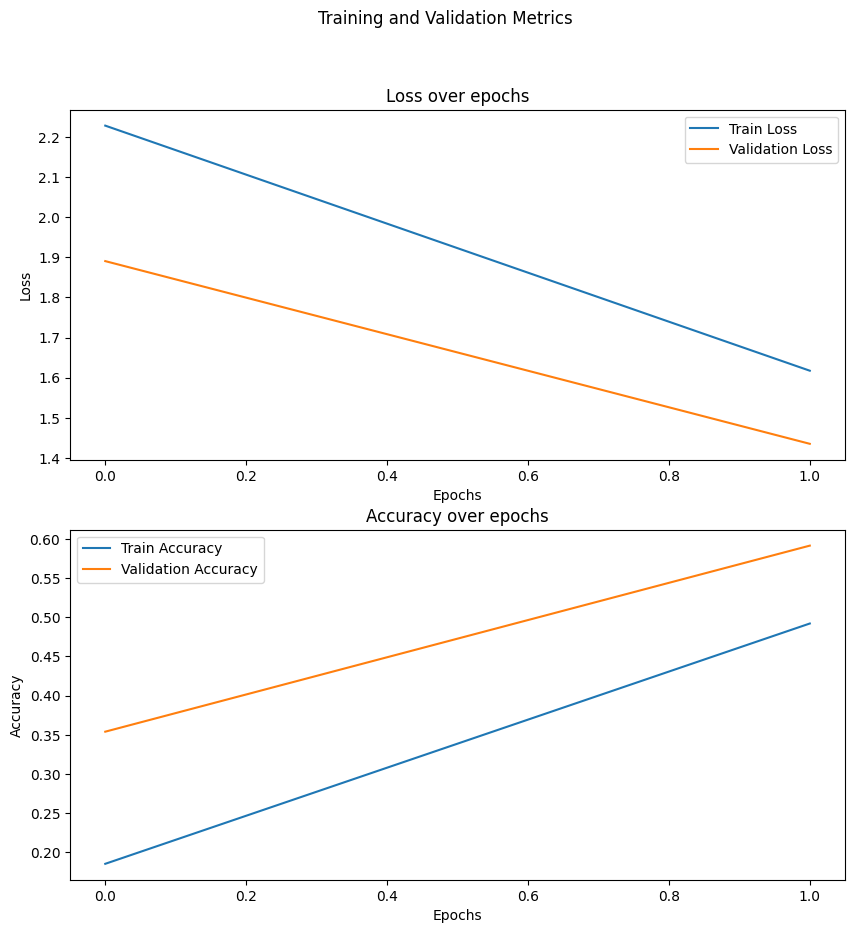

In [16]:
# Vit Training Loop For Learned Positional Embeddings 


learned_postional_embedding = PatchEmbeddingLearnedPositionalEmbedding(EMBEDING_DIMENTION, PATCH_SIZE, NUM_PATCHES, DROPUT, IN_CHANNELS)
model = Vit(learned_postional_embedding, NUM_PATCHES, IMAGE_SIZE, NUM_CLASSES, PATCH_SIZE, EMBEDING_DIMENTION, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPUT, ACTIVATION, IN_CHANNELS).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

best_val_loss = float('inf')
checkpoint_path = 'best_model.pt'

epochs_no_improve = 0
early_stop = False

start = timeit.default_timer()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0

    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_label["image"].float().to(device)
        label = img_label["label"].type(torch.uint8).to(device)
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())

        loss = criterion(y_pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    
    train_loss = train_running_loss / (idx+1)

    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0

    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)

            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred, label)

            val_running_loss += loss.item()

    val_loss = val_running_loss / (idx+1)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), checkpoint_path)
        print(f'Epoch {epoch+1}: New best model saved with val_loss: {val_loss:.4f}')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve == PATIANCE:
        print("Early stopping triggered")
        early_stop = True
        break

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracy = sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels)
    val_accuracy = sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Train Accuracy EPOCH {epoch+1}: {train_accuracy}")
    print(f"Valid Accuracy EPOCH {epoch+1}: {val_accuracy}")
    print("-"*30)

if not early_stop:
    print("Completed all epochs without early stopping.")

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
fig.suptitle('Training and Validation Metrics')

ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Loss over epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title('Accuracy over epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

In [17]:
model.load_state_dict(torch.load(checkpoint_path))
model.eval()
test_running_loss = 0
test_labels = []
test_preds = []
criterion = nn.CrossEntropyLoss()  

with torch.no_grad(): 
    for img_label in tqdm(test_dataloader, position=0, leave=True):
        img = img_label["image"].float().to(device)
        label = img_label["label"].type(torch.uint8).to(device)

        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        test_labels.extend(label.cpu().detach())
        test_preds.extend(y_pred_label.cpu().detach())

        loss = criterion(y_pred, label)
        test_running_loss += loss.item()

test_loss = test_running_loss / len(test_dataloader)
test_accuracy = sum(1 for x, y in zip(test_preds, test_labels) if x == y) / len(test_labels)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

  0%|          | 0/106 [00:00<?, ?it/s]

100%|██████████| 106/106 [00:08<00:00, 12.15it/s]

Test Loss: 1.4375
Test Accuracy: 0.5914
